In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

读入数据集

In [2]:
train = pd.read_csv("../input/quora-question-pairs-feature-extraction-2/train.csv")
test = pd.read_csv("../input/quora-question-pairs-feature-extraction-2/test.csv")
trainlabel = pd.read_csv("../input/quora-question-pairs-feature-extraction-2/trainlabel.csv")

In [3]:
dtrain = xgb.DMatrix(train, label = trainlabel)

## 设定scale_pos_weight
计算正例分布

In [4]:
p = 0.369197853026293
pos_public = (0.55410 + np.log(1 - p)) / np.log((1 - p) / p)
pos_private = (0.55525 + np.log(1 - p)) / np.log((1 - p) / p)
average = (pos_public + pos_private) / 2
print (pos_public, pos_private, average)

0.17424682519173934 0.17639371112774202 0.17532026815974067


## 定义weighted_log_loss

In [5]:
w0 = average * (1 - p) / ((1 - average) * p)
print(w0)

0.3632292393086082


In [6]:
w1 = average / p
w2 = (1 - average) / (1 - p)
print(w1, w2)

0.474868059829305 1.3073508639700833


In [7]:
def weighted_log_loss(preds, dtrain):
    label = dtrain.get_label()
    return "weighted_logloss", -np.mean(w1 * label * np.log(preds) + w2 * (1 - label) * np.log(1 - preds))

## 调整num_boost_round

In [8]:
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.1
params["max_depth"] = 6
params["min_child_weight"] = 1
params["gamma"] = 0
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"  # 使用GPU加速的直方图算法
params['max_bin'] = 256

model1 = xgb.cv(params, dtrain, num_boost_round = 2000, nfold = 10, 
                feval = weighted_log_loss, early_stopping_rounds = 200, 
                verbose_eval = 50)

[0]	train-logloss:0.634759+7.02923e-05	train-weighted_logloss:0.623622+9.99644e-05	test-logloss:0.634839+0.000291607	test-weighted_logloss:0.623696+0.00100518
[50]	train-logloss:0.321486+0.00043763	train-weighted_logloss:0.20286+0.000321448	test-logloss:0.324138+0.00363903	test-weighted_logloss:0.20488+0.00219108
[100]	train-logloss:0.306676+0.000570014	train-weighted_logloss:0.192694+0.000369073	test-logloss:0.312347+0.00363729	test-weighted_logloss:0.196903+0.00230343
[150]	train-logloss:0.298386+0.000598019	train-weighted_logloss:0.187574+0.000366055	test-logloss:0.307222+0.00367447	test-weighted_logloss:0.194099+0.00229949
[200]	train-logloss:0.292377+0.000449283	train-weighted_logloss:0.183811+0.000298574	test-logloss:0.30434+0.00365647	test-weighted_logloss:0.19263+0.00227717
[250]	train-logloss:0.287348+0.00042484	train-weighted_logloss:0.180729+0.000254256	test-logloss:0.302486+0.00366283	test-weighted_logloss:0.191832+0.00230327
[300]	train-logloss:0.282891+0.000426437	train-w

## 调整max_depth和min_weight
粗粒度调节

In [9]:
fix_params = {}
fix_params["objective"] = "binary:logistic"
fix_params["eval_metric"] = "logloss"
fix_params["eta"] = 0.1
fix_params["gamma"] = 0
fix_params["subsample"] = 0.8
fix_params["colsample_bytree"] = 0.9
fix_params["scale_pos_weight"] = 0.3632
fix_params["tree_method"] = "gpu_hist"
fix_params["max_bin"] = 256

evaluation_list = []
for depth in [5, 6]:
    for child_weight in [1, 2.5, 4]:
        params = {**fix_params, **{"max_depth": depth, "min_child_weight": child_weight}}
        evaluation = xgb.cv(params, dtrain, num_boost_round = 650, nfold = 6, 
                            feval = weighted_log_loss, early_stopping_rounds = 100)
        # evaluation记录了每一轮迭代的交叉验证结果
        evaluation_list.append(evaluation)
        
for depth in [7, 8]:
    for child_weight in [4, 5, 6]:
        params = {**fix_params, **{"max_depth": depth, "min_child_weight": child_weight}}
        evaluation = xgb.cv(params, dtrain, num_boost_round = 650, nfold = 6, 
                            feval = weighted_log_loss, early_stopping_rounds = 100)
        # evaluation记录了每一轮迭代的交叉验证结果
        evaluation_list.append(evaluation)

evaluation_panel = pd.DataFrame()
for evaluation in evaluation_list:
    # evaluation的最后一行即相应参数组合的结果
    evaluation_panel = pd.concat([evaluation_panel, evaluation.iloc[-1, :]], axis = 1)
evaluation_panel

,649,649,649,649,649,649,497,472,508,379,356,391
test-logloss-mean,0.299639,0.299818,0.300022,0.296271,0.296496,0.296799,0.295420,0.296186,0.295899,0.294930,0.295734,0.295567
test-logloss-std,0.002488,0.002403,0.002584,0.002416,0.002498,0.002576,0.002456,0.002366,0.002543,0.002440,0.002368,0.002430
test-weighted_logloss-mean,0.190885,0.190973,0.190908,0.190444,0.190283,0.190239,0.190193,0.190228,0.190176,0.190352,0.190338,0.190404
test-weighted_logloss-std,0.001524,0.001480,0.001553,0.001553,0.001602,0.001696,0.001520,0.001568,0.001649,0.001479,0.001384,0.001553
train-logloss-mean,0.276720,0.278095,0.279224,0.256770,0.260504,0.263115,0.255204,0.259223,0.258160,0.249334,0.255266,0.253585
train-logloss-std,0.000462,0.000314,0.000410,0.000540,0.000777,0.000503,0.000602,0.000583,0.000576,0.000560,0.000351,0.000355
train-weighted_logloss-mean,0.174246,0.175090,0.175791,0.161924,0.164172,0.165781,0.160860,0.163346,0.162705,0.157218,0.160877,0.159889
train-weighted_logloss-std,0.000305,0.000239,0.000277,0.000368,0.000495,0.000339,0.000400,0.000391,0.000366,0.000332,0.000214,0.000213


细粒度调节

In [10]:
fix_params = {}
fix_params["objective"] = "binary:logistic"
fix_params["eval_metric"] = "logloss"
fix_params["eta"] = 0.1
fix_params["gamma"] = 0
fix_params["subsample"] = 0.8
fix_params["colsample_bytree"] = 0.9
fix_params["scale_pos_weight"] = 0.3632
fix_params["tree_method"] = "gpu_hist"
fix_params["max_bin"] = 256

evaluation_list = []
for depth in [5, 6, 7]:
    for child_weight in [3, 3.5, 4, 4.5]:
        params = {**fix_params, **{"max_depth": depth, "min_child_weight": child_weight}}
        evaluation = xgb.cv(params, dtrain, num_boost_round = 650, nfold = 6, 
                            feval = weighted_log_loss, early_stopping_rounds = 100)
        evaluation_list.append(evaluation)

evaluation_panel = pd.DataFrame()
for evaluation in evaluation_list:
    evaluation_panel = pd.concat([evaluation_panel, evaluation.iloc[-1, :]], axis = 1)
evaluation_panel

,649,649,649,649,649,649,649,649,476,500,497,466
test-logloss-mean,0.299894,0.299870,0.300022,0.300072,0.296689,0.296817,0.296799,0.296996,0.295527,0.295577,0.295420,0.296260
test-logloss-std,0.002428,0.002399,0.002584,0.002318,0.002486,0.002506,0.002576,0.002438,0.002453,0.002551,0.002456,0.002482
test-weighted_logloss-mean,0.190945,0.190832,0.190908,0.190979,0.190395,0.190328,0.190239,0.190402,0.190186,0.190248,0.190193,0.190274
test-weighted_logloss-std,0.001498,0.001491,0.001553,0.001414,0.001609,0.001578,0.001696,0.001596,0.001636,0.001619,0.001520,0.001528
train-logloss-mean,0.278593,0.279125,0.279224,0.279594,0.261485,0.262322,0.263115,0.263708,0.254881,0.254063,0.255204,0.258704
train-logloss-std,0.000579,0.000397,0.000410,0.000556,0.000459,0.000462,0.000503,0.000459,0.000531,0.000409,0.000602,0.000683
train-weighted_logloss-mean,0.175409,0.175740,0.175791,0.176036,0.164782,0.165298,0.165781,0.166155,0.160677,0.160155,0.160860,0.163013
train-weighted_logloss-std,0.000386,0.000275,0.000277,0.000366,0.000328,0.000302,0.000339,0.000307,0.000382,0.000278,0.000400,0.000436


## 调整max_bin

In [11]:
fix_params = {}
fix_params["objective"] = "binary:logistic"
fix_params["eval_metric"] = "logloss"
fix_params["eta"] = 0.1
fix_params["gamma"] = 0
fix_params["subsample"] = 0.8
fix_params["colsample_bytree"] = 0.9
fix_params["scale_pos_weight"] = 0.3632
fix_params["tree_method"] = "gpu_hist"
fix_params["max_depth"] = 6
fix_params["min_child_weight"] = 4

evaluation_list = []
for bin in [200, 230, 256, 280]:
    params = {**fix_params, **{"max_bin": bin}}
    evaluation = xgb.cv(params, dtrain, num_boost_round = 650, nfold = 6, 
                        feval = weighted_log_loss, early_stopping_rounds = 100)
    evaluation_list.append(evaluation)

evaluation_panel = pd.DataFrame()
for evaluation in evaluation_list:
    evaluation_panel = pd.concat([evaluation_panel, evaluation.iloc[-1, :]], axis = 1)
evaluation_panel

,649,649,649,649
test-logloss-mean,0.296946,0.296899,0.296799,0.296869
test-logloss-std,0.002580,0.002513,0.002576,0.002415
test-weighted_logloss-mean,0.190354,0.190357,0.190239,0.190378
test-weighted_logloss-std,0.001667,0.001584,0.001696,0.001499
train-logloss-mean,0.263007,0.263045,0.263115,0.262703
train-logloss-std,0.000594,0.000612,0.000503,0.000525
train-weighted_logloss-mean,0.165729,0.165734,0.165781,0.165536
train-weighted_logloss-std,0.000413,0.000410,0.000339,0.000332


In [12]:
fix_params = {}
fix_params["objective"] = "binary:logistic"
fix_params["eval_metric"] = "logloss"
fix_params["eta"] = 0.08
fix_params["gamma"] = 0
fix_params["subsample"] = 0.8
fix_params["colsample_bytree"] = 0.9
fix_params["scale_pos_weight"] = 0.3632
fix_params["tree_method"] = "gpu_hist"
fix_params["max_depth"] = 6
fix_params["min_child_weight"] = 3.5

evaluation_list = []
for bin in [220, 240, 270]:
    params = {**fix_params, **{"max_bin": bin}}
    evaluation = xgb.cv(params, dtrain, num_boost_round = 650, nfold = 6, 
                        feval = weighted_log_loss, early_stopping_rounds = 100)
    evaluation_list.append(evaluation)

evaluation_panel = pd.DataFrame()
for evaluation in evaluation_list:
    evaluation_panel = pd.concat([evaluation_panel, evaluation.iloc[-1, :]], axis = 1)
evaluation_panel

,649,649,649
test-logloss-mean,0.297810,0.297706,0.297846
test-logloss-std,0.002381,0.002358,0.002565
test-weighted_logloss-mean,0.190284,0.190257,0.190366
test-weighted_logloss-std,0.001523,0.001496,0.001617
train-logloss-mean,0.269347,0.269498,0.269339
train-logloss-std,0.000333,0.000609,0.000380
train-weighted_logloss-mean,0.169652,0.169738,0.169621
train-weighted_logloss-std,0.000242,0.000412,0.000243


## 调整subsample和colsample_bytree
粗粒度调节

In [13]:
fix_params = {}
fix_params["objective"] = "binary:logistic"
fix_params["eval_metric"] = "logloss"
fix_params["eta"] = 0.1
fix_params["gamma"] = 0
fix_params["scale_pos_weight"] = 0.3632
fix_params["tree_method"] = "gpu_hist"
fix_params["max_depth"] = 6
fix_params["min_child_weight"] = 4
fix_params["max_bin"] = 256

evaluation_list = []
for row in [0.7, 0.8, 0.9]:
    for col in [0.7, 0.8, 0.9]:
        params = {**fix_params, **{"subsample": row, "colsample_bytree": col}}
        evaluation = xgb.cv(params, dtrain, num_boost_round = 650, nfold = 6, 
                            feval = weighted_log_loss, early_stopping_rounds = 100)
        evaluation_list.append(evaluation)

evaluation_panel = pd.DataFrame()
for evaluation in evaluation_list:
    evaluation_panel = pd.concat([evaluation_panel, evaluation.iloc[-1, :]], axis = 1)
evaluation_panel

,649,649,649,649,649,649,649,649,649
test-logloss-mean,0.297529,0.297085,0.297082,0.297037,0.296903,0.296799,0.297145,0.296989,0.296921
test-logloss-std,0.002477,0.002395,0.002531,0.002481,0.002526,0.002576,0.002429,0.002393,0.002533
test-weighted_logloss-mean,0.190612,0.190429,0.190454,0.190316,0.190253,0.190239,0.190319,0.190278,0.190279
test-weighted_logloss-std,0.001469,0.001516,0.001603,0.001492,0.001589,0.001696,0.001532,0.001489,0.001567
train-logloss-mean,0.264996,0.264335,0.263460,0.264254,0.263624,0.263115,0.264729,0.263919,0.263355
train-logloss-std,0.000400,0.000652,0.000409,0.000420,0.000385,0.000503,0.000440,0.000492,0.000458
train-weighted_logloss-mean,0.166954,0.166541,0.165998,0.166473,0.166099,0.165781,0.166780,0.166298,0.165933
train-weighted_logloss-std,0.000243,0.000434,0.000273,0.000240,0.000235,0.000339,0.000290,0.000324,0.000291


细粒度调节

In [14]:
fix_params = {}
fix_params["objective"] = "binary:logistic"
fix_params["eval_metric"] = "logloss"
fix_params["eta"] = 0.1
fix_params["gamma"] = 0
fix_params["scale_pos_weight"] = 0.3632
fix_params["tree_method"] = "gpu_hist"
fix_params["max_depth"] = 6
fix_params["min_child_weight"] = 4
fix_params["max_bin"] = 256

evaluation_list = []
for row in [0.75, 0.8, 0.85]:
    for col in [0.85, 0.9]:
        params = {**fix_params, **{"subsample": row, "colsample_bytree": col}}
        evaluation = xgb.cv(params, dtrain, num_boost_round = 650, nfold = 6, 
                            feval = weighted_log_loss, early_stopping_rounds = 100)
        evaluation_list.append(evaluation)

evaluation_panel = pd.DataFrame()
for evaluation in evaluation_list:
    evaluation_panel = pd.concat([evaluation_panel, evaluation.iloc[-1, :]], axis = 1)
evaluation_panel

,649,649,649,649,649,649
test-logloss-mean,0.297107,0.297019,0.297064,0.296799,0.296993,0.296911
test-logloss-std,0.002380,0.002376,0.002587,0.002576,0.002430,0.002394
test-weighted_logloss-mean,0.190382,0.190382,0.190378,0.190239,0.190357,0.190374
test-weighted_logloss-std,0.001562,0.001462,0.001607,0.001696,0.001477,0.001555
train-logloss-mean,0.263806,0.263200,0.263195,0.263115,0.263286,0.262782
train-logloss-std,0.000608,0.000438,0.000456,0.000503,0.000518,0.000619
train-weighted_logloss-mean,0.166210,0.165869,0.165825,0.165781,0.165919,0.165601
train-weighted_logloss-std,0.000399,0.000280,0.000304,0.000339,0.000328,0.000369


## 调整eta和num_boost_round

In [15]:
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.06
params["gamma"] = 0
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 4
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9

model6 = xgb.cv(params, dtrain, num_boost_round = 6000, nfold = 10, 
                feval = weighted_log_loss, early_stopping_rounds = 150, 
                verbose_eval = 50)

[0]	train-logloss:0.657305+4.20501e-05	train-weighted_logloss:0.650569+0.000114187	test-logloss:0.657351+0.000175539	test-weighted_logloss:0.650612+0.00111213
[50]	train-logloss:0.332097+0.000490849	train-weighted_logloss:0.218352+0.000272754	test-logloss:0.333685+0.00314723	test-weighted_logloss:0.219607+0.0019442
[100]	train-logloss:0.318321+0.000419685	train-weighted_logloss:0.200287+0.000284357	test-logloss:0.321307+0.00362387	test-weighted_logloss:0.20254+0.00221326
[150]	train-logloss:0.309791+0.000449484	train-weighted_logloss:0.194623+0.000287813	test-logloss:0.314466+0.00367186	test-weighted_logloss:0.198093+0.00228025
[200]	train-logloss:0.303828+0.000488887	train-weighted_logloss:0.190935+0.000313327	test-logloss:0.310269+0.00363093	test-weighted_logloss:0.195713+0.00224672
[250]	train-logloss:0.299367+0.000402035	train-weighted_logloss:0.188203+0.000256349	test-logloss:0.307552+0.00368643	test-weighted_logloss:0.194251+0.00227892
[300]	train-logloss:0.295766+0.000384017	tra

In [16]:
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.04
params["gamma"] = 0
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 4
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9

model4 = xgb.cv(params, dtrain, num_boost_round = 6000, nfold = 10, 
                feval = weighted_log_loss, early_stopping_rounds = 150, 
                verbose_eval = 50)

[0]	train-logloss:0.668978+2.83304e-05	train-weighted_logloss:0.664471+0.000123119	test-logloss:0.669008+0.00011726	test-weighted_logloss:0.6645+0.00116836
[50]	train-logloss:0.347283+0.000396291	train-weighted_logloss:0.246077+0.000243693	test-logloss:0.348415+0.00277397	test-weighted_logloss:0.246999+0.0016983
[100]	train-logloss:0.325928+0.000434352	train-weighted_logloss:0.208215+0.000271178	test-logloss:0.327923+0.00352232	test-weighted_logloss:0.209766+0.00215857
[150]	train-logloss:0.318607+0.000474931	train-weighted_logloss:0.200456+0.000300074	test-logloss:0.321501+0.00365383	test-weighted_logloss:0.202646+0.00226829
[200]	train-logloss:0.312369+0.000494173	train-weighted_logloss:0.196226+0.000308761	test-logloss:0.316369+0.0037101	test-weighted_logloss:0.199207+0.00234432
[250]	train-logloss:0.30754+0.000357479	train-weighted_logloss:0.193232+0.000230484	test-logloss:0.312717+0.00383375	test-weighted_logloss:0.197076+0.00240246
[300]	train-logloss:0.303814+0.000375371	train-w

In [17]:
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["gamma"] = 0
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 4
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9

model2 = xgb.cv(params, dtrain, num_boost_round = 6000, nfold = 10, 
                feval = weighted_log_loss, early_stopping_rounds = 150, 
                verbose_eval = 50)

[0]	train-logloss:0.680925+1.43279e-05	train-weighted_logloss:0.678663+0.000132558	test-logloss:0.68094+5.8868e-05	test-weighted_logloss:0.678678+0.001226
[50]	train-logloss:0.409694+0.000270815	train-weighted_logloss:0.337218+0.000176285	test-logloss:0.4103+0.0018721	test-weighted_logloss:0.337741+0.00102212
[100]	train-logloss:0.347244+0.000366838	train-weighted_logloss:0.246864+0.000227617	test-logloss:0.348385+0.00279919	test-weighted_logloss:0.247795+0.00171622
[150]	train-logloss:0.332204+0.000400055	train-weighted_logloss:0.219145+0.000248282	test-logloss:0.333776+0.00324428	test-weighted_logloss:0.220389+0.00198172
[200]	train-logloss:0.326058+0.000419357	train-weighted_logloss:0.208447+0.000264353	test-logloss:0.328062+0.0034779	test-weighted_logloss:0.210005+0.00213073
[250]	train-logloss:0.321934+0.000414153	train-weighted_logloss:0.203407+0.000268534	test-logloss:0.324379+0.00361255	test-weighted_logloss:0.205281+0.00222427
[300]	train-logloss:0.3185+0.000400401	train-weigh

## 训练最终模型并提交

In [18]:
params = {}
params["objective"] = "binary:logistic"
params["eval_metric"] = "logloss"
params["eta"] = 0.02
params["gamma"] = 0
params["scale_pos_weight"] = 0.3632
params["tree_method"] = "gpu_hist"
params["max_depth"] = 6
params["min_child_weight"] = 4
params["max_bin"] = 256
params["subsample"] = 0.8
params["colsample_bytree"] = 0.9


dtest = xgb.DMatrix(test)

t = pd.read_csv("../input/quora-question-pairs/test.csv")

In [19]:
cv_res= xgb.cv(params, dtrain, num_boost_round = 6000, nfold = 10, 
                feval = weighted_log_loss, early_stopping_rounds = 150, 
                verbose_eval = 50)

[0]	train-logloss:0.680925+1.43279e-05	train-weighted_logloss:0.678663+0.000132558	test-logloss:0.68094+5.8868e-05	test-weighted_logloss:0.678678+0.001226
[50]	train-logloss:0.409694+0.000270815	train-weighted_logloss:0.337218+0.000176285	test-logloss:0.4103+0.0018721	test-weighted_logloss:0.337741+0.00102212
[100]	train-logloss:0.347244+0.000366838	train-weighted_logloss:0.246864+0.000227617	test-logloss:0.348385+0.00279919	test-weighted_logloss:0.247795+0.00171622
[150]	train-logloss:0.332204+0.000400055	train-weighted_logloss:0.219145+0.000248282	test-logloss:0.333776+0.00324428	test-weighted_logloss:0.220389+0.00198172
[200]	train-logloss:0.326058+0.000419357	train-weighted_logloss:0.208447+0.000264353	test-logloss:0.328062+0.0034779	test-weighted_logloss:0.210005+0.00213073
[250]	train-logloss:0.321934+0.000414153	train-weighted_logloss:0.203407+0.000268534	test-logloss:0.324379+0.00361255	test-weighted_logloss:0.205281+0.00222427
[300]	train-logloss:0.3185+0.000400401	train-weigh

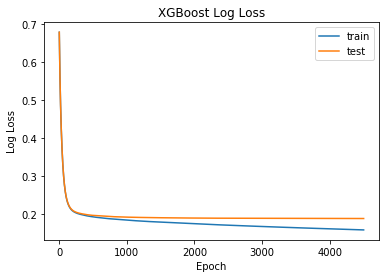

In [20]:
import matplotlib.pyplot as plt
plt.plot(cv_res['train-weighted_logloss-mean'], label='train')
plt.plot(cv_res['test-weighted_logloss-mean'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.legend()
plt.savefig('log_loss.jpg', dpi=700)

In [21]:
model = xgb.train(params, dtrain, num_boost_round = 3600)
prediction = model.predict(dtest)

sub = pd.DataFrame()
sub['test_id'] = t["test_id"]
sub['is_duplicate'] = prediction
sub.to_csv('submission3600.csv', index=False)

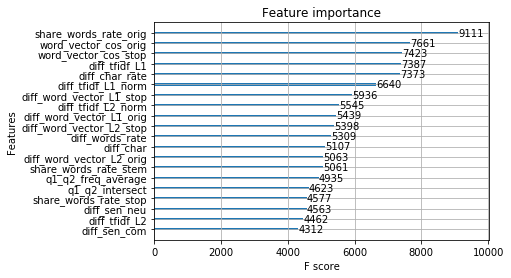

In [22]:
xgb.plot_importance(model, max_num_features=20, importance_type='weight')

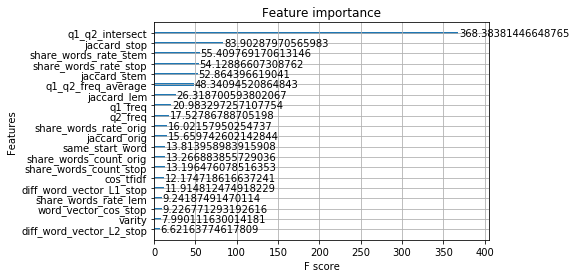

In [23]:
xgb.plot_importance(model, max_num_features=20, importance_type='gain')

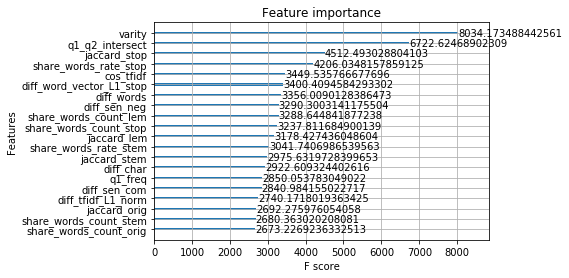

In [24]:
xgb.plot_importance(model, max_num_features=20, importance_type='cover')

In [25]:
model = xgb.train(params, dtrain, num_boost_round = 3800)
prediction = model.predict(dtest)

sub = pd.DataFrame()
sub['test_id'] = t["test_id"]
sub['is_duplicate'] = prediction
sub.to_csv('submission3800.csv', index=False)

In [26]:
model = xgb.train(params, dtrain, num_boost_round = 4100)
prediction = model.predict(dtest)

sub = pd.DataFrame()
sub['test_id'] = t["test_id"]
sub['is_duplicate'] = prediction
sub.to_csv('submission4100.csv', index=False)